# Import Snapshots from OpenFOAM files
This notebook import the Snapshots from OpenFOAM case, generating a mesh and extracting the set of fields.

In [4]:
from pyforce.tools.write_read import ReadFromOF

path_snaps = '../../../Data/MSFR/'

of = ReadFromOF(path_snaps+'ULOFF-reflector/', mode='pyvista')

Let us define the variables to extract

In [5]:
var_names = ['T', 'fluxTot', 'flux1']
is_vector = [False, False, False]

snaps = dict()
for field_i, field in enumerate(var_names):
    snaps[field], fom_times = of.import_field(field, is_vector[field_i])


Importing T using pyvista
Importing fluxTot using pyvista
Importing flux1 using pyvista


Let us create the mesh

In [7]:
domain = of.create_mesh()

  warnings.warn('The mesh contains more than one cell type.')



Hexahedron cells selected


Let us map the OpenFOAM snapshots to `dolfinx.fem.Function` objects

In [9]:
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1))
]

fun_lists = dict()
for field_i, field in enumerate(var_names):
    fun_lists[field] = of.foam_to_dolfinx(fun_spaces[field_i], snaps[field], verbose='Mapping ' + field,
                                          variables=['x', 'z'], cut_value=0.0)

Mapping T: 275.000 / 275.00 - 0.084 s/it
Mapping fluxTot: 275.000 / 275.00 - 0.084 s/it
Mapping flux1: 275.000 / 275.00 - 0.084 s/it


Let us make a plot

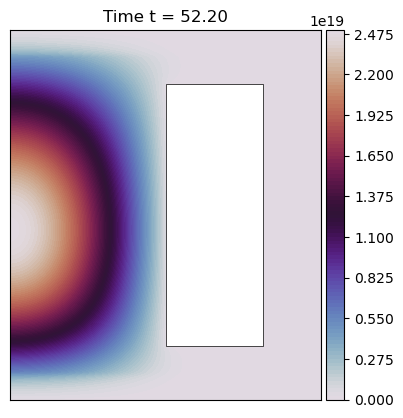

In [33]:
from utils import plot_contour
from matplotlib import cm
from IPython.display import clear_output as clc
import numpy as np
import matplotlib.pyplot as plt

field = 'fluxTot'
vec_mode_to_plot = 'Mag' if field == 'U' else None

for tt in range(0, len(fom_times), 20):
    fig,axs = plt.subplots()
    cont = plot_contour(axs, np.stack([domain.geometry.x[:, 0], domain.geometry.x[:, 2]]).T, fun_lists[field](tt), 
                        vec_mode_to_plot=vec_mode_to_plot, levels = 100, cmap=cm.twilight)

    axs.set_title('Time t = %.2f' % fom_times[tt])

    fig.colorbar(cont, ax=axs, pad=0.01)
    plt.show()
    clc(wait=True)
    plt.close(fig)

Let us save the variable names and the snapshots

In [34]:
import os

os.makedirs('Results', exist_ok=True)

np.savez_compressed('Results/variables', var_names=var_names, is_vector=is_vector)
np.savez_compressed('Results/times', fom_times=fom_times)

for field in var_names:
    np.savez_compressed('Results/' + field, field=fun_lists[field].return_matrix())